In [1]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pylab as pl
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
#collecting my images as gray scale and resizing them to match the lfw dataset
my_images_folder = 'C:/Users/Alfredo/Desktop/Alfredo_Gonzalez'
my_images = []
for filename in os.listdir(my_images_folder):
    img = cv2.imread(os.path.join(my_images_folder, filename), cv2.IMREAD_GRAYSCALE) / 255.0
    img = cv2.resize(img, (125, 125))
    my_images.append(img)


#loading the lfw dataset and extracting their labels for svm
lfw_folder = 'C:/Users/Alfredo/Desktop/lfw'
lfw_images = []
lfw_labels = []
for person_name in os.listdir(lfw_folder):
    person_folder = os.path.join(lfw_folder, person_name)
    for filename in os.listdir(person_folder):
        img = cv2.imread(os.path.join(person_folder, filename), cv2.IMREAD_GRAYSCALE) / 255.0
        img = cv2.resize(img, (125, 125))
        lfw_images.append(img)
        lfw_labels.append(person_name)

In [3]:
#Create a new dataset
X = np.concatenate([my_images, lfw_images], axis=0)
#adding label 1 to my images and label 0 if its not me
y = np.concatenate([np.ones(len(my_images)), np.zeros(len(lfw_images))], axis=0)

In [4]:
print("Number of pictures in the lfw dataset:" ,len(lfw_images))
print("Number of pictures in mypictures datasat:",len(my_images))
#prints out number of combined pictures + labels
print(len(X))
print(len(y))
print(np.sum(y == 1))

Number of pictures in the lfw dataset: 13233
Number of pictures in mypictures datasat: 10197
23430
23430
10197


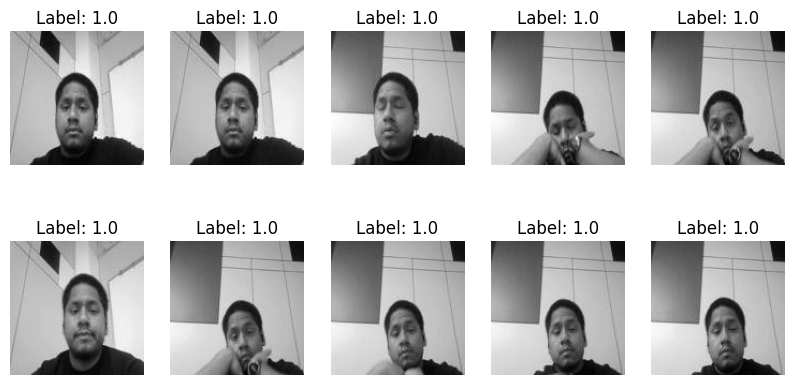

In [5]:
# Display the first 10 images in the X dataset
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i in range(10):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(X[i], cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title(f"Label: {y[i]}")
plt.show()

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#Extract features using PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train.reshape((X_train.shape[0], -1)))
X_test_pca = pca.fit_transform(X_test.reshape((X_test.shape[0], -1)))

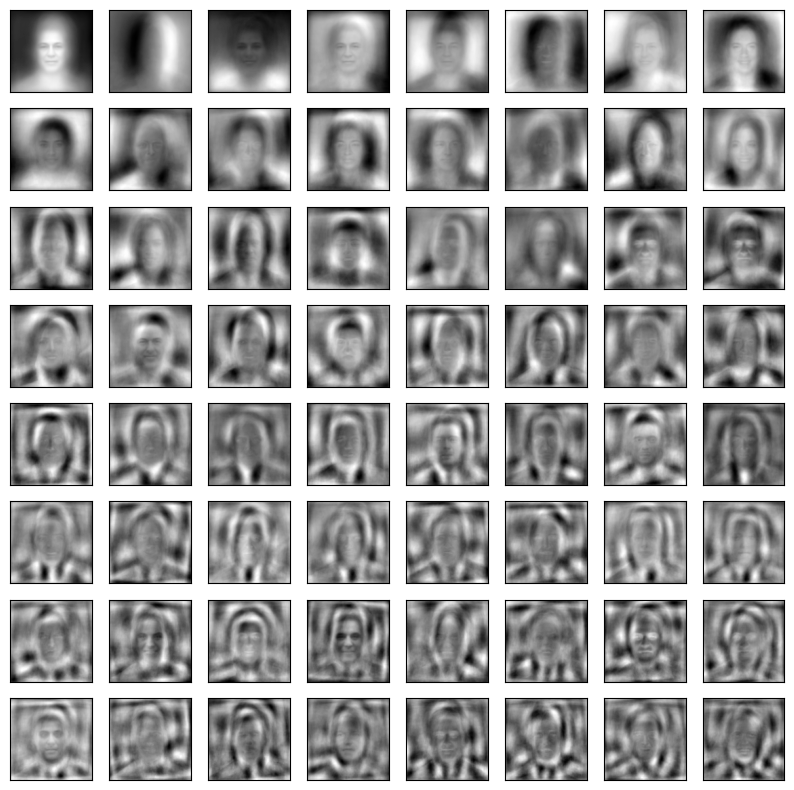

In [8]:
#show the effects of using PCA
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(125,125), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

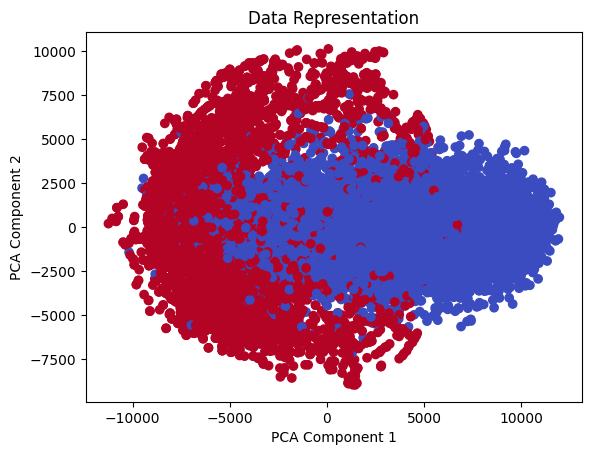

In [9]:
# Plot the training data points
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Data Representation')
plt.show()

In [10]:
#define param grid
param_grid = {'C': [.1,1,10,100], 'gamma':[.1,1,10,100]}

grid_search = GridSearchCV(SVC(kernel="rbf", probability= True, random_state=42), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
svm = grid_search.fit(X_train_pca, y_train)
print("The best params:", grid_search.best_params_)

SVC(C=1, kernel='linear', probability=True, random_state=42)

In [11]:
#Evaluate the SVM model on the testing dataset
y_pred = svm.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

Accuracy: 0.86


In [12]:
y_scores = svm.predict_proba(X_test_pca)[:, 1]

# compute fpr, tpr, and thresholds for various threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

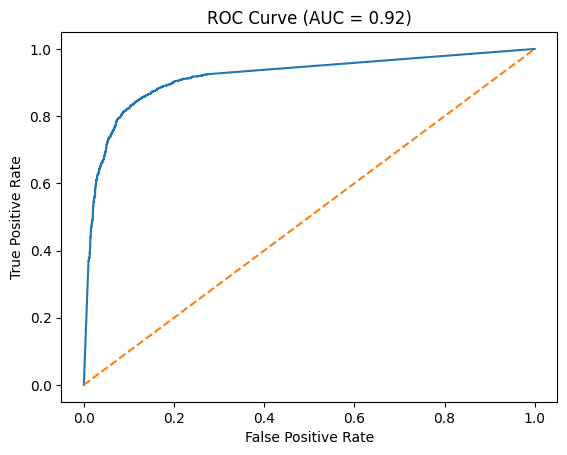

1788
2047


In [13]:
# compute the AUC score
auc_score = roc_auc_score(y_test,y_scores)
# plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()
print(np.sum(y_pred == 1))
print(np.sum(y_test == 1))

In [14]:
#display confustion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(classification_report(y_test, y_pred))

[[2451  188]
 [ 447 1600]]
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89      2639
         1.0       0.89      0.78      0.83      2047

    accuracy                           0.86      4686
   macro avg       0.87      0.86      0.86      4686
weighted avg       0.87      0.86      0.86      4686



The new image is not you


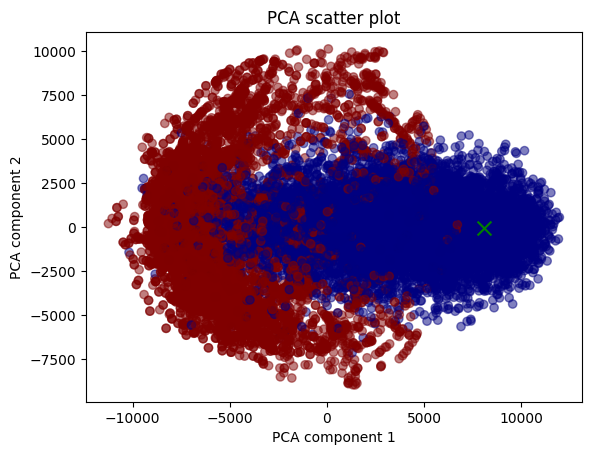

In [15]:
#Test the model on a new image
new_image = cv2.imread('C:/Users/Alfredo/desktop/randompic.png', cv2.IMREAD_GRAYSCALE)
new_image = cv2.resize(new_image, (125, 125))
new_image_pca = pca.transform(new_image.reshape((1, -1)))
prob = svm.predict_proba(new_image_pca)[0, 1]  # probability that the new image is you
if prob >= 0.5:
    print("The new image is you")
else:
    print("The new image is not you")


# plot the locations of the training data
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='jet', alpha=0.5)

# plot the location of the new image
new_image_pca = pca.transform(new_image.reshape((1, -1)))
plt.scatter(new_image_pca[:, 0], new_image_pca[:, 1], marker='x', color='green', s=100)

plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('PCA scatter plot')
plt.show()

The new image is you


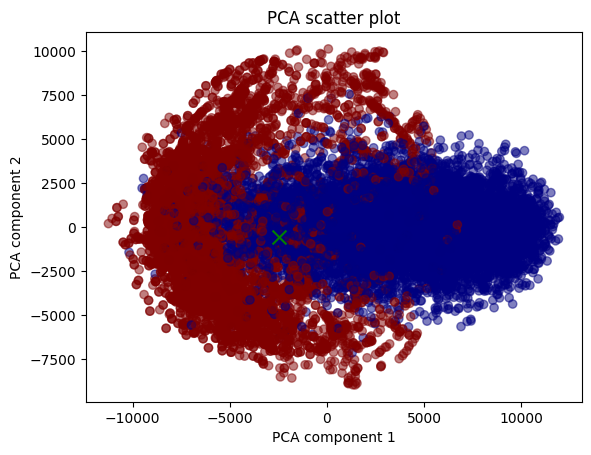

In [16]:
#Test the model on a new image
new_image = cv2.imread('C:/Users/Alfredo/desktop/me.png', cv2.IMREAD_GRAYSCALE)
new_image = cv2.resize(new_image, (125, 125))
new_image_pca = pca.transform(new_image.reshape((1, -1)))
predicted_class = svm.predict(new_image_pca)[0]
if predicted_class == 1:
    print("The new image is you")
else:
    print("The new image is not you")

# plot the locations of the training data
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='jet', alpha=0.5)

# plot the location of the new image
new_image_pca = pca.transform(new_image.reshape((1, -1)))
plt.scatter(new_image_pca[:, 0], new_image_pca[:, 1], marker='x', color='green', s=100)

plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('PCA scatter plot')
plt.show()

The new image is not you


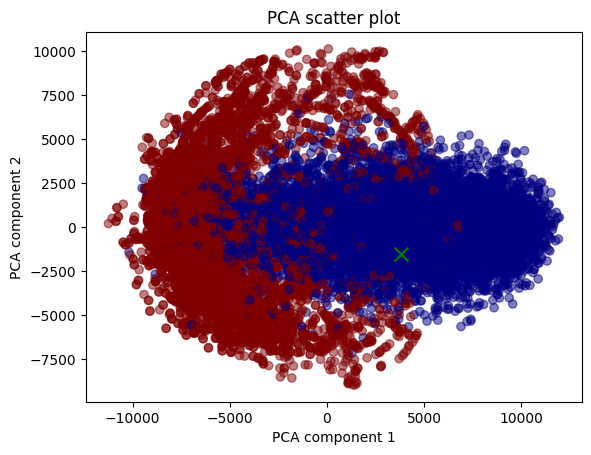

In [17]:
#Test the model on a new image
new_image = cv2.imread('C:/Users/Alfredo/desktop/notme.png', cv2.IMREAD_GRAYSCALE)
new_image = cv2.resize(new_image, (125, 125))
new_image_pca = pca.transform(new_image.reshape((1, -1)))
predicted_class = svm.predict(new_image_pca)[0]
if predicted_class == 1:
    print("The new image is you")
else:
    print("The new image is not you")

# plot the locations of the training data
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='jet', alpha=0.5)

# plot the location of the new image
new_image_pca = pca.transform(new_image.reshape((1, -1)))
plt.scatter(new_image_pca[:, 0], new_image_pca[:, 1], marker='x', color='green', s=100)

plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('PCA scatter plot')
plt.show()